# CELLxGENE Discover Census Workshop - CSHL Single-Cell Analysis 2023

This notebook is a step-by-step walkthrough of the CELLxGENE Discover Census Workshop at CSHL's Single-Cell Analysis, 2023.

Original notebook: [colab.research.google.com/drive/158f6Ggl5MRxtnxC9Q01TjJMbkIPQxcim](https://colab.research.google.com/drive/158f6Ggl5MRxtnxC9Q01TjJMbkIPQxcim)

## License

MIT License

Copyright (c) 2022-2023 Chan Zuckerberg Initiative Foundation.

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

## Workshop

### Installation

To install the Census API on your laptop you should follow the [installation instructions](https://chanzuckerberg.github.io/cellxgene-census/cellxgene_census_docsite_installation.html) in the documentation site.

### Census Hello World

Let's load the necessary libraries

In [1]:
library("tiledb")
library("cellxgene.census")
library("tiledbsoma")

Let's also set some configuration settings for SOMA. This allows us to set the size of data we stream at any given time, as this will be relevant when we cover SOMA iterators.

In [2]:
# Default: 1GB
# TileDB-Cloud can run default, but recommended for workshop is 10MB

# 10MB
py.init_buffer_bytes <- 0.01 * 1024**3
# 10MB
soma.init_buffer_bytes <- 0.01 * 1024**3

ctx = new_SOMATileDBContext_for_census(
  py.init_buffer_bytes = py.init_buffer_bytes,
  soma.init_buffer_bytes  = soma.init_buffer_bytes,
)

Workaround [census#1261](https://github.com/chanzuckerberg/cellxgene-census/issues/1261):

In [3]:
Sys.setenv(AWS_DEFAULT_REGION = "us-west-2")

#### Finding Census versions available

Let's first take a look at the data releases available in S3. There are two types of releases:
- **Long-term supported (LTS) data releases** published every six months to be available for up to 5 years.
- **Weekly releases** to be available for up to 6 weeks.

To see a list of all available releases and their version aliases, we can do the following

In [4]:
get_census_version_directory()

,release_date,release_build,soma.uri,soma.relative_uri,soma.s3_region,h5ads.uri,h5ads.relative_uri,h5ads.s3_region,do_not_delete,lts,alias
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>
stable,,2024-07-01,s3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/soma/,/cell-census/2024-07-01/soma/,us-west-2,s3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/h5ads/,/cell-census/2024-07-01/h5ads/,us-west-2,TRUE,TRUE,stable
latest,,2024-09-02,s3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/,/cell-census/2024-09-02/soma/,us-west-2,s3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/h5ads/,/cell-census/2024-09-02/h5ads/,us-west-2,FALSE,NA,latest
2023-05-15,,2023-05-15,s3://cellxgene-census-public-us-west-2/cell-census/2023-05-15/soma/,/cell-census/2023-05-15/soma/,us-west-2,s3://cellxgene-census-public-us-west-2/cell-census/2023-05-15/h5ads/,/cell-census/2023-05-15/h5ads/,us-west-2,TRUE,TRUE,
2023-07-25,,2023-07-25,s3://cellxgene-census-public-us-west-2/cell-census/2023-07-25/soma/,/cell-census/2023-07-25/soma/,us-west-2,s3://cellxgene-census-public-us-west-2/cell-census/2023-07-25/h5ads/,/cell-census/2023-07-25/h5ads/,us-west-2,TRUE,TRUE,
2023-12-15,,2023-12-15,s3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/,/cell-census/2023-12-15/soma/,us-west-2,s3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/h5ads/,/cell-census/2023-12-15/h5ads/,us-west-2,TRUE,TRUE,
2024-05-20,,2024-05-20,s3://cellxgene-census-public-us-west-2/cell-census/2024-05-20/soma/,/cell-census/2024-05-20/soma/,us-west-2,s3://cellxgene-census-public-us-west-2/cell-census/2024-05-20/h5ads/,/cell-census/2024-05-20/h5ads/,us-west-2,TRUE,NA,
2024-07-01,,2024-07-01,s3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/soma/,/cell-census/2024-07-01/soma/,us-west-2,s3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/h5ads/,/cell-census/2024-07-01/h5ads/,us-west-2,TRUE,TRUE,
2024-08-05,,2024-08-05,s3://cellxgene-census-public-us-west-2/cell-census/2024-08-05/soma/,/cell-census/2024-08-05/soma/,us-west-2,s3://cellxgene-census-public-us-west-2/cell-census/2024-08-05/h5ads/,/cell-census/2024-08-05/h5ads/,us-west-2,FALSE,NA,
2024-08-12,,2024-08-12,s3://cellxgene-census-public-us-west-2/cell-census/2024-08-12/soma/,/cell-census/2024-08-12/soma/,us-west-2,s3://cellxgene-census-public-us-west-2/cell-census/2024-08-12/h5ads/,/cell-census/2024-08-12/h5ads/,us-west-2,FALSE,NA,


#### List Census LTS versions

In [5]:
lts_census <- get_census_version_directory()
lts_census[lts_census$lts,]

,release_date,release_build,soma.uri,soma.relative_uri,soma.s3_region,h5ads.uri,h5ads.relative_uri,h5ads.s3_region,do_not_delete,lts,alias
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>
stable,,2024-07-01,s3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/soma/,/cell-census/2024-07-01/soma/,us-west-2,s3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/h5ads/,/cell-census/2024-07-01/h5ads/,us-west-2,TRUE,TRUE,stable
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2023-05-15,,2023-05-15,s3://cellxgene-census-public-us-west-2/cell-census/2023-05-15/soma/,/cell-census/2023-05-15/soma/,us-west-2,s3://cellxgene-census-public-us-west-2/cell-census/2023-05-15/h5ads/,/cell-census/2023-05-15/h5ads/,us-west-2,TRUE,TRUE,
2023-07-25,,2023-07-25,s3://cellxgene-census-public-us-west-2/cell-census/2023-07-25/soma/,/cell-census/2023-07-25/soma/,us-west-2,s3://cellxgene-census-public-us-west-2/cell-census/2023-07-25/h5ads/,/cell-census/2023-07-25/h5ads/,us-west-2,TRUE,TRUE,
2023-12-15,,2023-12-15,s3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/,/cell-census/2023-12-15/soma/,us-west-2,s3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/h5ads/,/cell-census/2023-12-15/h5ads/,us-west-2,TRUE,TRUE,
NA.1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2024-07-01,,2024-07-01,s3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/soma/,/cell-census/2024-07-01/soma/,us-west-2,s3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/h5ads/,/cell-census/2024-07-01/h5ads/,us-west-2,TRUE,TRUE,
NA.2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


#### Opening a Census version

Now we can get a handle to the Census object hosted in S3. Remember that we can specify the data release to use.

In [6]:
# For the latest LTS use "stable", other options are "latest" for the latest
# weekly, or specific version

version <- "2024-09-02"

# Equivalent (at time of writing), but will emit a warning advising to pin a specific version
# version <- "latest"

census <- open_soma(census_version = version, tiledbsoma_ctx = ctx)

#### Inspecting the Census object

These are the types of SOMA objects used by Census:

- `SparseNDArray` is the same as DenseNDArray but sparse, and supports point indexing (disjoint index access).
- `DataFrame` is a multi-column table with user-defined columns names and value types, with support for point indexing.
- `Collection` is a persistent container of named SOMA objects, similar to a dictionary.
- `Experiment` is a class that represents a single-cell experiment. It always contains two objects:
   - `obs`: a `DataFrame` with primary annotations on the observation axis.
   - `ms`: a `Collection` of measurements, each composed of `X` matrices and axis annotation matrices or data frames (e.g. `var`, `varm`, `obsm`, etc).

The parent Census object is a SOMA `Collection`:

In [7]:
census

<SOMACollection>
  uri: s3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/ 
  groups: census_data*, census_info* 

You can access items of a collection with square brackets.

- `"census_data"` has the Census single-cell data, will explore it in a momemnt.
- `"census_info"` has high-level summary information about Census

Let's take a look at `"census_info"`

**🚨 NOTE:** To access elements of a SOMA collection we need to use the R6 method `$get()`


In [8]:
census$get("census_info")

<SOMACollection>
  uri: s3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info 
  arrays: datasets*, organisms*, summary_cell_counts*, summary* 

There are three items in this collection:

- `"summary"`: A data frame with high-level information of this Census, e.g. build date, total cell count, etc.
- `"summary_cell_counts"`: A data frame with cell counts stratified by relevant cell metadata
- `"datasets"`: A data frame with all datasets from CELLxGENE Discover used to create the Census.

Now let's take a look at `"census_data"`.

In [9]:
census$get("census_data")

<SOMACollection>
  uri: s3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data 
  groups: homo_sapiens*, mus_musculus* 

These two are SOMA `Experiment` objects which are a specialized form of a `Collection`. Each of these store a data matrix (cells by genes), cell metadata, gene metadata, and some other useful components.

### Reading Data Frames


#### Reading cell metadata

Let's take a deeper dive into the single-cell data. As mentioned earlier, an `Experiment` always has an `obs` atrribute that can be accessed via `$obs`.

Let's take a look at the human `Experiment`.

In [10]:
census$get("census_data")$get("homo_sapiens")

<SOMAExperiment>
  uri: s3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data/homo_sapiens 
  arrays: obs* 
  groups: ms* 

In [11]:
census$get("census_data")$get("homo_sapiens")$obs

<SOMADataFrame>
  uri: s3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data/homo_sapiens/obs 
  dimensions: soma_joinid 
  attributes: dataset_id, assay, assay_ontology_term_id, cell_type, cell_type_ontology_term... 

We can take a look at the columns available in a data frame with the `schema()` method, which shows the types of metadata available for each cell.

In [12]:
census$get("census_data")$get("homo_sapiens")$obs$schema()

Schema
soma_joinid: int64 not null
dataset_id: dictionary<values=string, indices=int16>
assay: dictionary<values=string, indices=int8>
assay_ontology_term_id: dictionary<values=string, indices=int8>
cell_type: dictionary<values=string, indices=int16>
cell_type_ontology_term_id: dictionary<values=string, indices=int16>
development_stage: dictionary<values=string, indices=int16>
development_stage_ontology_term_id: dictionary<values=string, indices=int16>
disease: dictionary<values=string, indices=int8>
disease_ontology_term_id: dictionary<values=string, indices=int8>
donor_id: dictionary<values=string, indices=int16>
is_primary_data: bool
observation_joinid: string
self_reported_ethnicity: dictionary<values=string, indices=int8>
self_reported_ethnicity_ontology_term_id: dictionary<values=string, indices=int8>
sex: dictionary<values=string, indices=int8>
sex_ontology_term_id: dictionary<values=string, indices=int8>
suspension_type: dictionary<values=string, indices=int8>
tissue: dictionar

Let's read two columns of the data frame.

In [13]:
obs <- census$get("census_data")$get("homo_sapiens")$obs$read(column_names=c("suspension_type", "tissue_general"))$concat()
head(as.data.frame(obs))

,suspension_type,tissue_general
,<fct>,<fct>
1,cell,liver
2,cell,liver
3,cell,liver
4,cell,liver
5,cell,liver
6,cell,liver


The line above retrieved the suspension type and tissue values for all human cells in Census. Let's dissect step-by-step to see what happened there:


1. `$read(column_names = c("suspension_type", "tissue_general")` - creates an iterator of Arrow tables that can be used for chunked-based data streaming.
2. `$concat()` - retrieves all the results of the iterator and concatenates them into a single Arrow table.
3. `as.data.frame(obs)` - converts the Arrow table into a data frame.

Let's do each step one more time and inspect the intermediate objects.

In [14]:
# Create iterator of Arrow tables
iterator <- census$get("census_data")$get("homo_sapiens")$obs$read(column_names=c("suspension_type", "tissue_general"))
iterator

<TableReadIter>
  Inherits from: <ReadIter>
  Public:
    clone: function (deep = FALSE) 
    concat: function () 
    initialize: function (sr) 
    read_complete: function () 
    read_next: function () 
  Private:
    .read_next: function () 
    .readComplete: function () 
    soma_reader_pointer: externalptr
    soma_reader_transform: function (x) 

In [15]:
# We can get individual chunks
table_chunk <- iterator$read_next()
table_chunk

Table
10737418 rows x 2 columns
$suspension_type <dictionary<values=string, indices=int8>>
$tissue_general <dictionary<values=string, indices=int8>>

In [16]:
head(as.data.frame(table_chunk))

,suspension_type,tissue_general
,<fct>,<fct>
1,cell,liver
2,cell,liver
3,cell,liver
4,cell,liver
5,cell,liver
6,cell,liver


In [17]:
# Or concatenate the remaining results into a single Arrow Table,
# and the convert to a DataFrame
table <- iterator$concat()
df_obs <- as.data.frame(table)
head(df_obs)

,suspension_type,tissue_general
,<fct>,<fct>
1,cell,lung
2,cell,lung
3,cell,lung
4,cell,lung
5,cell,lung
6,cell,lung


In [18]:
# And you can perform operations useful for your analysis
table(df_obs$suspension_type)


    cell  nucleus 
37775285 29153096 

#### Summary info and dataset table

The same reading operations can be applied to any SOMA data frame in Census. Let's take a look back at the items of `"census_info"`.

In [19]:
census$get("census_info")

<SOMACollection>
  uri: s3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info 
  arrays: datasets*, organisms*, summary_cell_counts*, summary* 

`"summary"` is a data frame with high-level information of this data release.

In [20]:
census$get("census_info")$get("summary")

<SOMADataFrame>
  uri: s3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/summary 
  dimensions: soma_joinid 
  attributes: label, value 

In [21]:
as.data.frame(census$get("census_info")$get("summary")$read()$concat())

soma_joinid,label,value
<int>,<chr>,<chr>
0,census_schema_version,2.1.0
1,census_build_date,2024-09-02
2,dataset_schema_version,5.1.0
3,total_cell_count,120108090
4,unique_cell_count,64161082
5,number_donors_homo_sapiens,19993
6,number_donors_mus_musculus,4698


And `"datasets"` is data frame listing all of the datasets whose single-cell data is contained in this Census release.

**🚨 NOTE:** the column `dataset_id` is also present in the cell metadata for joining

In [22]:
datasets <- census$get("census_info")$get("datasets")$read()$concat()
head(as.data.frame(datasets))

,soma_joinid,citation,collection_id,collection_name,collection_doi,collection_doi_label,dataset_id,dataset_version_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,0,Publication: https://doi.org/10.1002/hep4.1854 Dataset Version: https://datasets.cellxgene.cziscience.com/aaab3abd-624a-442e-b62b-3f2edb10b45e.h5ad curated and distributed by CZ CELLxGENE Discover in Collection: https://cellxgene.cziscience.com/collections/44531dd9-1388-4416-a117-af0a99de2294,44531dd9-1388-4416-a117-af0a99de2294,"Single-Cell, Single-Nucleus, and Spatial RNA Sequencing of the Human Liver Identifies Cholangiocyte and Mesenchymal Heterogeneity",10.1002/hep4.1854,Andrews et al. (2022) Hepatology Communications,0895c838-e550-48a3-a777-dbcd35d30272,aaab3abd-624a-442e-b62b-3f2edb10b45e,Healthy human liver: B cells,0895c838-e550-48a3-a777-dbcd35d30272.h5ad,146
2,1,Publication: https://doi.org/10.1126/sciimmunol.abe6291 Dataset Version: https://datasets.cellxgene.cziscience.com/50c1d621-995d-4386-9fcb-5c70fcdf8d66.h5ad curated and distributed by CZ CELLxGENE Discover in Collection: https://cellxgene.cziscience.com/collections/3a2af25b-2338-4266-aad3-aa8d07473f50,3a2af25b-2338-4266-aad3-aa8d07473f50,Single-cell analysis of human B cell maturation predicts how antibody class switching shapes selection dynamics,10.1126/sciimmunol.abe6291,King et al. (2021) Sci. Immunol.,00ff600e-6e2e-4d76-846f-0eec4f0ae417,50c1d621-995d-4386-9fcb-5c70fcdf8d66,Human tonsil nonlymphoid cells scRNA,00ff600e-6e2e-4d76-846f-0eec4f0ae417.h5ad,363
3,2,Publication: https://doi.org/10.1038/s41593-020-00764-7 Dataset Version: https://datasets.cellxgene.cziscience.com/e95b54b1-8656-4fe8-9f53-6fdd97f397ba.h5ad curated and distributed by CZ CELLxGENE Discover in Collection: https://cellxgene.cziscience.com/collections/180bff9c-c8a5-4539-b13b-ddbc00d643e6,180bff9c-c8a5-4539-b13b-ddbc00d643e6,Molecular characterization of selectively vulnerable neurons in Alzheimer's Disease,10.1038/s41593-020-00764-7,Leng et al. (2021) Nat Neurosci,bdacc907-7c26-419f-8808-969eab3ca2e8,e95b54b1-8656-4fe8-9f53-6fdd97f397ba,Molecular characterization of selectively vulnerable neurons in Alzheimer’s Disease: SFG microglia,bdacc907-7c26-419f-8808-969eab3ca2e8.h5ad,3799
4,3,Publication: https://doi.org/10.1038/s41467-022-29450-x Dataset Version: https://datasets.cellxgene.cziscience.com/d6e742c5-f6e5-42f4-8064-622783542f6b.h5ad curated and distributed by CZ CELLxGENE Discover in Collection: https://cellxgene.cziscience.com/collections/bf325905-5e8e-42e3-933d-9a9053e9af80,bf325905-5e8e-42e3-933d-9a9053e9af80,Single-cell Atlas of common variable immunodeficiency shows germinal center-associated epigenetic dysregulation in B-cell responses,10.1038/s41467-022-29450-x,Rodríguez-Ubreva et al. (2022) Nat Commun,a5d95a42-0137-496f-8a60-101e17f263c8,d6e742c5-f6e5-42f4-8064-622783542f6b,Steady-state B cells - scRNA-seq,a5d95a42-0137-496f-8a60-101e17f263c8.h5ad,1324
5,4,Publication: https://doi.org/10.1038/s41590-021-01059-0 Dataset Version: https://datasets.cellxgene.cziscience.com/61f15353-e598-43b5-bb5a-80ac44a0cf0b.h5ad curated and distributed by CZ CELLxGENE Discover in Collection: https://cellxgene.cziscience.com/collections/93eebe82-d8c3-41bc-a906-63b5b5f24a9d,93eebe82-d8c3-41bc-a906-63b5b5f24a9d,Single-cell proteo-genomic reference maps of the hematopoietic system enable the purification and massive profiling of precisely defined cell states,10.1038/s41590-021-01059-0,Triana et al. (2021) Nat Immunol,d3566d6a-a455-4a15-980f-45eb29114cab,61f15353-e598-43b5-bb5a-80ac44a0cf0b,blood and bone marrow from a healthy young donor,d3566d6a-a455-4a15-980f-45eb29114cab.h5ad,15502
6,5,Publication: https://doi.org/10.1016/j.celrep.2019.12.082 Dataset Version: https://datasets.cellxgene.cziscience.com/76b42c8c-9357-4c13-908f-8b757a0f8637.h5ad curated and distributed by CZ CELLxGENE Discover in Collection: https://cellxgene.cziscience.com/collections/9

#### Reading gene metadata

Reading gene metadata is similar to reading cell metadata. However the location of this data frame is inside the soma Measurement. This was designed to allow for multi-modal data, whereby the same observation (cell) can have a different set of features for each type of measurement (e.g. genes, proteins).


To read the gene metadata:

In [23]:
# Build iterator
iterator <- census$get("census_data")$get("homo_sapiens")$ms$get("RNA")$var$read()

# Grab first chunk
table_chunk <- iterator$read_next()

# Convert to data frame
head(as.data.frame(table_chunk))

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
,<int>,<chr>,<chr>,<int>,<int>,<int>
1,0,ENSG00000000003,TSPAN6,4530,4811135,77128603
2,1,ENSG00000000005,TNMD,1476,269136,64017621
3,2,ENSG00000000419,DPM1,9276,18420588,77502438
4,3,ENSG00000000457,SCYL3,6883,9268173,76952827
5,4,ENSG00000000460,C1orf112,5970,6484239,76979490
6,5,ENSG00000000938,FGR,3382,6159591,77404789


#### Reading a Data Frame with row filters

SOMA makes it easy and efficient to only select a subset of rows based on a query filter. This helps when you want to grab data or metadata only for specific set of cells or genes based on the columns available in these data frames.

For example if you want to get the all the the *primary cells* you can add the following.

**🚨 NOTE:** cells annotated as `is_primary_data = True` are those marked as the original contribution, as some cells are represented more than once in Census due to their inclusion in multiple datasets.

In [24]:
# Build iterator with a query filter
iterator <- census$get("census_data")$get("homo_sapiens")$obs$read(
    value_filter = "is_primary_data == True"
)

# Grab first chunk
table_chunk <- iterator$read_next()

# Convert to data frame
head(as.data.frame(table_chunk))

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,⋯,tissue,tissue_ontology_term_id,tissue_type,tissue_general,tissue_general_ontology_term_id,raw_sum,nnz,raw_mean_nnz,raw_variance_nnz,n_measured_vars
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<int>
1,4308,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old human stage,HsapDv:0000120,normal,PATO:0000461,⋯,blood,UBERON:0000178,tissue,blood,UBERON:0000178,17691,1199,14.75480,624.621,19149
2,4309,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old human stage,HsapDv:0000120,normal,PATO:0000461,⋯,blood,UBERON:0000178,tissue,blood,UBERON:0000178,13612,841,16.18549,1394.944,19149
3,4310,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old human stage,HsapDv:0000120,normal,PATO:0000461,⋯,blood,UBERON:0000178,tissue,blood,UBERON:0000178,126774,1683,75.32620,42215.147,19149
4,4311,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old human stage,HsapDv:0000120,normal,PATO:0000461,⋯,blood,UBERON:0000178,tissue,blood,UBERON:0000178,14370,371,38.73315,4639.991,19149
5,4312,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old human stage,HsapDv:0000120,normal,PATO:0000461,⋯,blood,UBERON:0000178,tissue,blood,UBERON:0000178,13738,507,27.09665,3874.080,19149
6,4313,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,unswitched memory B cell,CL:0000970,26-year-old human stage,HsapDv:0000120,normal,PATO:0000461,⋯,blood,UBERON:0000178,tissue,blood,UBERON:0000178,273713,1699,161.10241,169532.067,19149


The `value_filter` works similalrly to a Pandas `query` interface. It can take a string of which is evaluated as a boolean condition and selects rows that meet the criteria.

We can then use other operators to build complex queries, for example all epithelial cells from lung that are primary representations.

In [25]:
filter <- "is_primary_data == True & cell_type == 'epithelial cell' & tissue_general == 'lung'"
columns <- c("assay")

# Build iterator
iterator <- census$get("census_data")$get("homo_sapiens")$obs$read(
    value_filter = filter,
    column_names = columns,
)

# Grab first chunk
table_chunk <- iterator$read_next()

# Convert to data frame and get unique values
unique(as.data.frame(table_chunk))

,assay
,<fct>
1,Smart-seq2
202,10x 3' v3
3209,10x 3' v2
25807,microwell-seq
27236,10x 3' transcription profiling
59330,10x 5' transcription profiling
59342,10x 5' v2


#### Reading a Data Frame with coordinates

Finally, you can also read a data frame via coordinates. This is useful when testing code with a small set of data.

In [26]:
obs <- census$get("census_data")$get("homo_sapiens")$obs$read(coords=1:5)$concat()
as.data.frame(obs)

soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,⋯,tissue,tissue_ontology_term_id,tissue_type,tissue_general,tissue_general_ontology_term_id,raw_sum,nnz,raw_mean_nnz,raw_variance_nnz,n_measured_vars
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<int>
1,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,mature B cell,CL:0000785,human adult stage,HsapDv:0000087,normal,PATO:0000461,⋯,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,278,143,1.944056,3.616567,13696
2,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,plasma cell,CL:0000786,human adult stage,HsapDv:0000087,normal,PATO:0000461,⋯,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,3723,709,5.251058,2959.510327,13696
3,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,mature B cell,CL:0000785,human adult stage,HsapDv:0000087,normal,PATO:0000461,⋯,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,351,179,1.960894,8.487226,13696
4,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,mature B cell,CL:0000785,human adult stage,HsapDv:0000087,normal,PATO:0000461,⋯,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,605,275,2.200000,18.978102,13696
5,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,mature B cell,CL:0000785,human adult stage,HsapDv:0000087,normal,PATO:0000461,⋯,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,338,164,2.060976,11.444112,13696


### Reading expression data

The single-cell expression data is stored as a SOMA `SparseNDArray`. This is a sparse representation of the data that enables efficient storage and access for data with a high number of missing values.

Currently Census has two expression layers:

- Raw counts.
- Normalized counts by library size.

For human, these are located in the \"RNA\" measurement at:

- `"census_data" --> "homo_sapiens"]$ms --> "RNA"$X --> "raw"`
- `"census_data" --> "homo_sapiens"]$ms --> "RNA"$X --> "normalized"`

Reading these data works similarly to reading data frames. The main difference is that there are different types of iterators available. In this workshop we'll focus on `Matrix::dgTMatrix` iterators.


In [27]:
# Creater a reader
reader <- census$get("census_data")$get("homo_sapiens")$ms$get("RNA")$X$get("raw")$read()

# Build an iterator of Matrix::dgTMatrix objects
iterator <- reader$sparse_matrix()

# Grab first chunk
sparse_chunk <- iterator$read_next()

# Convert to data frame
str(sparse_chunk)

Formal class 'dgTMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:1342177] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ j       : int [1:1342177] 176 229 249 409 451 653 990 1092 1366 1526 ...
  ..@ Dim     : int [1:2] 77665799 60537
  ..@ Dimnames:List of 2
  .. ..$ : NULL
  .. ..$ : NULL
  ..@ x       : num [1:1342177] 1 1 1 1 1 1 1 3 1 1 ...
  ..@ factors : list()


This produces an expression matrix in COO sparse format using `Matrix::dgTMatrix`:

- `i` - the ID + 1 for the cell.
- `j` - the ID + 1 for the gene.  
- `soma_data` - the expression value.


In [28]:
dim(sparse_chunk)

[1] 77665799    60537

**🚨 NOTE:** Reading the expression matrix in isolation is usually not very useful without cell and gene metadata. We'll cover that in the next section.
**🚨 NOTE:** The shape of this matrix is 63,094,145 rows by 60,664 columns (the full size of Census). We have a "sparse" view.

### Atomic reading of expression data AND metadata

SOMA provides a convenient interface to query single-cell data in a metadata-aware fashion using `ExperimentAxisQuery`.

We covered in a previous section the concept of an SOMA `Experiment`, as a class that represents a single-cell experiment. It always contains two objects:
   - `obs`: a `DataFrame` with primary annotations on the observation axis.
   - `ms`: a `Collection` of measurements, each composed of `X` matrices and axis annotation matrices or data frames (e.g. `var`, `varm`, `obsm`, etc).

**🚨 NOTE:** An `ExperimentAxisQuery` enables users to query and slice an `Experiment` single-cell data and metadata using coordinates or value filters on the axes, similar to how a SOMA `DataFrame` is queried.

#### Creating an `ExperimentAxisQuery`

To create an `ExperimentAxisQuery` you can call the method `$axis_query()` of a SOMA `Experiment`.

In [29]:
cell_filter <- "tissue_general == 'tongue' & cell_type %in% c('leukocyte', 'keratinocyte')"
gene_filter <- "feature_name %in% c('PECAM1', 'DCN', 'KRT13')"

query <- census$get("census_data")$get("homo_sapiens")$axis_query(
    measurement_name = "RNA",
    obs_query = SOMAAxisQuery$new(value_filter = cell_filter),
    var_query = SOMAAxisQuery$new(value_filter = gene_filter)
)

In [30]:
query

<SOMAExperimentAxisQuery>
  Public:
    clone: function (deep = FALSE) 
    experiment: active binding
    indexer: active binding
    initialize: function (experiment, measurement_name, obs_query = NULL, var_query = NULL) 
    ms: active binding
    n_obs: active binding
    n_vars: active binding
    obs: function (column_names = NULL) 
    obs_df: active binding
    obs_joinids: function () 
    obs_query: active binding
    obsm: function (layer_name) 
    obsp: function (layer_name) 
    read: function (X_layers = NULL, obs_column_names = NULL, var_column_names = NULL) 
    to_seurat: function (X_layers = c(counts = "counts", data = "logcounts"), 
    to_seurat_assay: function (X_layers = c(counts = "counts", data = "logcounts"), 
    to_seurat_graph: function (obsp_layer, obs_index = NULL) 
    to_seurat_reduction: function (obsm_layer, varm_layer = NULL, obs_index = NULL, var_index = NULL) 
    to_single_cell_experiment: function (X_layers = NULL, obs_index = NULL, var_index = N

#### Inspecting the query results

Once the `ExperimentAxisQuery` is created you have access to a variety of convenient methods to fetch data or useful information about your query.

In [31]:
# Number of cells in query
query$n_obs

[1] 17328

In [32]:
# Number of cells in query
query$n_vars

[1] 3

In [33]:
# Grabing cell metadata
iterator <- query$obs(column_names = c("cell_type", "tissue_general"))
unique(as.data.frame(iterator$concat()))

,cell_type,tissue_general
,<fct>,<fct>
1,leukocyte,tongue
880,keratinocyte,tongue


In [34]:
# Grabing gene metadata
iterator <- query$var()
as.data.frame(iterator$concat())

soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
<int>,<chr>,<chr>,<int>,<int>,<int>
299,ENSG00000011465,DCN,12941,7905731,75319655
12852,ENSG00000171401,KRT13,2913,712612,62927690
28763,ENSG00000261371,PECAM1,7741,7739030,64633082


#### Exporting query results to `Seurat`

`ExperimentAxisQuery` has the capability to export the query to an `AnnData` object to use for downstream analysis with Scanpy.

In [35]:
if (!requireNamespace("remotes", quietly = TRUE)) {
  install.packages("remotes")
}

On macOS, this may require installing [gfortran-12.2-universal.pkg](https://mac.r-project.org/tools/gfortran-12.2-universal.pkg) from [cran.r-project.org/bin/macosx/tools](https://cran.r-project.org/bin/macosx/tools/).

(Otherwise, `RcppEigen` will fail to install, with an error like `ld: library 'gfortran' not found`; [SO](https://stackoverflow.com/questions/77836548/library-gfortran-not-found-when-installing-r-packages))

In [36]:
remotes::install_version("SeuratObject", "4.1.4", repos = c("https://satijalab.r-universe.dev", getOption("repos")))

In [37]:
remotes::install_version("Seurat", "4.4.0", repos = c("https://satijalab.r-universe.dev", getOption("repos")))

SeuratObject (4.1.4 -> 5.0.2) [CRAN]


Installing 1 packages: SeuratObject



In [38]:
# Convert to Seurat
seurat <- query$to_seurat(X_layers = c(data = "normalized"), var_index = "feature_name")
seurat

An object of class Seurat 
3 features across 17328 samples within 1 assay 
Active assay: RNA (3 features, 0 variable features)
 1 layer present: data

Warning message:
“Scaling data with a low number of groups may produce misleading results”


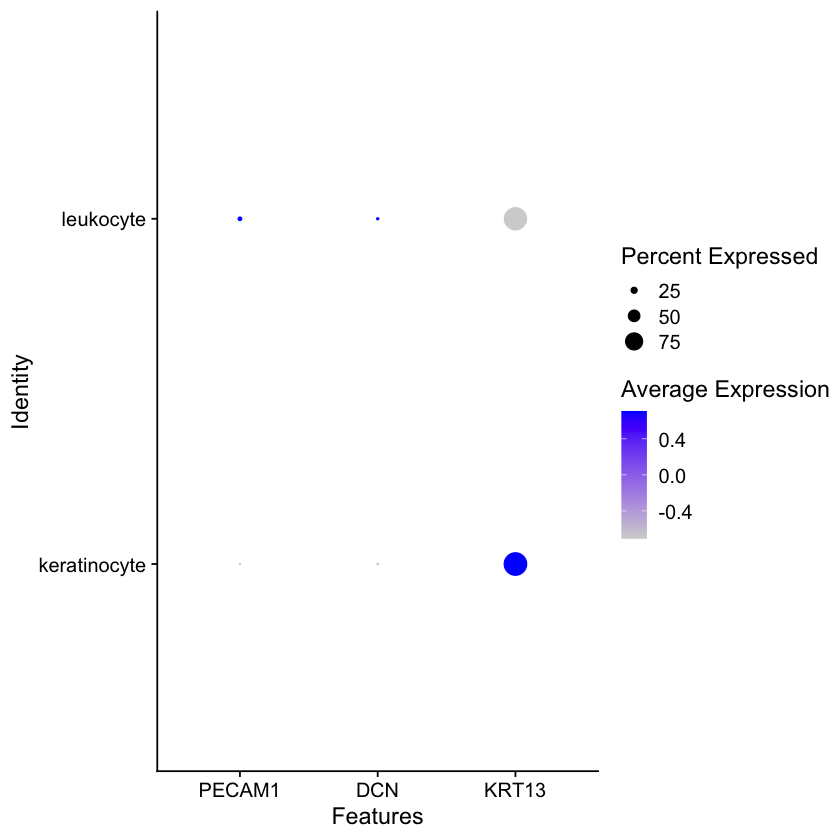

In [39]:
# Example: doing an expression dot plot
Seurat::DotPlot(seurat, features = c('PECAM1', 'DCN', 'KRT13'), group.by="cell_type")

**🚨 NOTE:** The Census package provide a convinient way to get a Seurat object without creating an Experiment Query:

```r
seurat_obj <- get_seurat(
   census = census,
   organism = organism,
   var_value_filter = gene_filter,
   obs_value_filter = cell_filter,
   obs_column_names = cell_columns
)
```


#### Exporting query results to `SingleCellExperiment`

`ExperimentAxisQuery` has the capability to export the query to a `SingleCellExperiment` object to use for downstream analysis.

In [40]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

In [41]:
BiocManager::install("SingleCellExperiment")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'SingleCellExperiment'”
Old packages: 'boot', 'foreign', 'MASS', 'nlme', 'Seurat', 'survival'



In [42]:
# Convert to Seurat
sce <- query$to_single_cell_experiment(X_layers = c(data = "normalized"), var_index = "feature_name")
sce

class: SingleCellExperiment 
dim: 3 17328 
metadata(0):
assays(1): data
rownames(3): DCN KRT13 PECAM1
rowData names(4): feature_id feature_length nnz n_measured_obs
colnames(17328): obs6765727 obs6765733 ... obs53548547 obs53548548
colData names(27): dataset_id assay ... raw_variance_nnz
  n_measured_vars
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

**🚨 NOTE:** The Census package provide a convinient way to get a SingleCellExperiment object without creating an Experiment Query:

```r
sce_obj <- get_single_cell_experiment(
   census = census,
   organism = organism,
   var_value_filter = gene_filter,
   obs_value_filter = cell_filter,
   obs_column_names = cell_columns
)
```


#### Getting the expression data and metadata

An`ExperimentAxisQuery` has all the necessary functionality to obtain the expression matrix along the corresponding cell and gene metadata.

`to_anndata()` (shown in the previous section) uses many of these methods under the hood.

Let's take a closer look. First, we can get the cell and gene metadata as follows:

In [43]:
# Get cell metadata, only cell types and SOMA IDs
obs <- query$obs(column_names = c("soma_joinid", "cell_type"))$concat()
obs <- as.data.frame(obs)
head(obs)

,soma_joinid,cell_type
,<int>,<fct>
1,6765727,leukocyte
2,6765733,leukocyte
3,6765742,leukocyte
4,6765745,leukocyte
5,6765746,leukocyte
6,6765749,leukocyte


In [44]:
# Get gene metadata
var <- query$var()$concat()
var <- as.data.frame(var)
var

soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
<int>,<chr>,<chr>,<int>,<int>,<int>
299,ENSG00000011465,DCN,12941,7905731,75319655
12852,ENSG00000171401,KRT13,2913,712612,62927690
28763,ENSG00000261371,PECAM1,7741,7739030,64633082


Now let's take a look at expression matrix. There's a method `X()` that works similarly to reading a SOMA `SparseNDArray`, it retunrs a reader that can be then used to create matrix iterators.

Importantly `X()` will only return the rows and columns corresponding to cells and genes in the query, respectively.

In [45]:
# Get reader, results, and concatenate them.
# We need to specify the layer.
X = query$X(layer_name = "raw")$sparse_matrix()$concat()
str(X)

Formal class 'dgTMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:19380] 6765742 6765826 6765877 6765885 6766017 6766049 6766158 6766237 6766238 6766517 ...
  ..@ j       : int [1:19380] 299 299 299 299 299 299 299 299 299 299 ...
  ..@ Dim     : int [1:2] 77665799 60537
  ..@ Dimnames:List of 2
  .. ..$ : NULL
  .. ..$ : NULL
  ..@ x       : num [1:19380] 1 1 2 1 1 1 1 1 1 1 ...
  ..@ factors : list()


In [46]:
dim(X)

[1] 77665799    60537

**🚨 NOTE:** The shape of this matrix is 63,094,145 rows by 60,664 columns (the full size of Census).

However we know that there are 17K cells and 3 genes in our query. The reason for this discrepancy is that we are taking a "view" at the Census matrix in sparse format.

We can re-index these values to strip away all other cells and genes not included in our query result. The R package has a convinient function to get a re-indexed concatanted result.

In [47]:
x_reindexed <- query$to_sparse_matrix(collection = "X", layer_name = "raw", var_index="feature_name")
dim(x_reindexed)

[1] 17328     3

In [48]:
x_reindexed[1:4,]

4 x 3 sparse Matrix of class "dgTMatrix"
        DCN KRT13 PECAM1
6765727   .    18      .
6765733   .    21      .
6765742   1    12      .
6765745   .    14      .

**🚨 NOTE:** Just like a file, the Census should be closed.

In [49]:
census$close()

### Efficient compute capabilities of Census

Census has some methods that makes use of SOMA streaming capabilities (iterators) to make it possible to apply common calculations on million of cells, using a common laptop.


#### Calculating average and variance across genes or cells

**🚨 NOTE:** This functionality is curretly only available in the Python package `cellxgene_census`

#### Getting highly variable genes

**🚨 NOTE:** This functionality is curretly only available in the Python package `cellxgene_census`

### Scalable modelling with PyTorch and Census

Census provides an `ExperimentDataPipe`. It is an implementation of [PyTorch's DataPipe interface](https://pytorch.org/data/main/torchdata.datapipes.iter.html), which defines a common mechanism for wrapping and accessing training data from any underlying source.

**🚨 NOTE:** This functionality is curretly only available in the Python package `cellxgene_census`